In [35]:
import sys
import os
import numpy as np
import seaborn as sns
import optuna
from matplotlib import pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Utils'), '..')))
from Utils.data_utils import load_preprocessed_data_from_folder



In [36]:
# Load the data from the CSV file into a pandas DataFrame
data = load_preprocessed_data_from_folder()

data

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.513755,0.571139,0.336096,0.543891,0.680385,0.669439,0.313402,0.699753,0.286091,0.0
1,0.265434,0.297400,0.300611,0.491839,0.610408,0.719411,0.497319,0.450999,0.576793,0.0
2,0.578509,0.641311,0.321619,0.698543,0.584737,0.414652,0.562017,0.532866,0.303637,0.0
3,0.594055,0.605536,0.356244,0.603314,0.647347,0.317880,0.622089,0.808065,0.601015,0.0
4,0.649445,0.484851,0.289922,0.484900,0.514545,0.379337,0.358555,0.253606,0.496327,0.0
...,...,...,...,...,...,...,...,...,...,...
3991,0.482531,0.524160,0.308924,0.442628,0.504566,0.407946,0.539767,0.485483,0.599330,1.0
3992,0.371926,0.442095,0.411976,0.546609,0.596498,0.292375,0.416480,0.524698,0.460797,1.0
3993,0.471553,0.290820,0.524454,0.747456,0.432994,0.558864,0.430764,0.599290,0.580482,1.0
3994,0.483064,0.484272,0.490260,0.783886,0.364165,0.535721,0.349975,0.552053,0.439660,1.0


# naive model

In [37]:
TEST_SIZE = 0.1
NUM_FOLDS = 5

train_df, test_df = train_test_split(data, test_size=TEST_SIZE)
train_df, test_df

(            ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
 210   0.419267  0.581422  0.359951     0.488905  0.635070      0.496858   
 2623  0.725301  0.713758  0.401191     0.341241  0.485178      0.360414   
 2747  0.471965  0.667897  0.428525     0.722178  0.821636      0.457861   
 2909  0.566345  0.666759  0.281151     0.464955  0.574935      0.362890   
 2521  0.588639  0.716955  0.290291     0.705708  0.629533      0.284289   
 ...        ...       ...       ...          ...       ...           ...   
 1876  0.598084  0.479119  0.356313     0.380669  0.597937      0.376339   
 823   0.484581  0.598531  0.205343     0.551988  0.589368      0.256269   
 97    0.392022  0.320540  0.347488     0.613340  0.430654      0.454391   
 3284  0.602449  0.445073  0.222642     0.561306  0.626970      0.442357   
 845   0.470889  0.707487  0.148758     0.544124  0.522155      0.453114   
 
       Organic_carbon  Trihalomethanes  Turbidity  Potability  
 210         0.484218 

In [38]:
train_x = train_df.drop('Potability', axis=1)
train_y = train_df['Potability']

test_x = test_df.drop('Potability', axis=1)
test_y = test_df['Potability']

In [39]:
oModel = SVC()
oModel.fit(train_x, train_y)

print(f'SVC test F1 score: {f1_score(test_y, oModel.predict(test_x)):0.2%}')

SVC test F1 score: 69.10%


In [43]:
naive_predictions = oModel.predict(test_x)

naive_accuracy = accuracy_score(test_y, naive_predictions)
naive_f1 = f1_score(test_y, naive_predictions)
naive_precision = precision_score(test_y, naive_predictions)
naive_recall = recall_score(test_y, naive_predictions)
print(f"Naive Model Performance:")
print(f"Accuracy: {naive_accuracy:.2%}")
print(f"F1 Score: {naive_f1:.2%}")
print(f"Precision: {naive_precision:.2%}")
print(f"Recall: {naive_recall:.2%}")

Naive Model Performance:
Accuracy: 68.25%
F1 Score: 69.10%
Precision: 67.62%
Recall: 70.65%


# optuna

In [44]:
def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    degree = trial.suggest_int('degree', 1, 3)
    classifier = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, random_state=42)
    scores = cross_val_score(classifier, train_x, train_y, cv=NUM_FOLDS, scoring='f1')
    return np.mean(scores)

In [45]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-04-20 18:21:27,940] A new study created in memory with name: no-name-030fd379-384f-4219-ac37-43cb848afb9b
[I 2024-04-20 18:21:29,318] Trial 0 finished with value: 0.0 and parameters: {'C': 324.76712703608234, 'kernel': 'sigmoid', 'gamma': 'scale', 'degree': 3}. Best is trial 0 with value: 0.0.
[I 2024-04-20 18:21:30,671] Trial 1 finished with value: 0.0 and parameters: {'C': 824.6390643602016, 'kernel': 'sigmoid', 'gamma': 'scale', 'degree': 3}. Best is trial 0 with value: 0.0.
[I 2024-04-20 18:21:36,831] Trial 2 finished with value: 0.7080979608029123 and parameters: {'C': 303.6339833245831, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 2}. Best is trial 2 with value: 0.7080979608029123.
[I 2024-04-20 18:21:37,781] Trial 3 finished with value: 0.4646334429610041 and parameters: {'C': 110.14799490618002, 'kernel': 'sigmoid', 'gamma': 'auto', 'degree': 1}. Best is trial 2 with value: 0.7080979608029123.
[I 2024-04-20 18:21:39,464] Trial 4 finished with value: 0.5817902476248811 a

C:\Users\main\AppData\Local\Temp\ipykernel_24152\3222002628.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


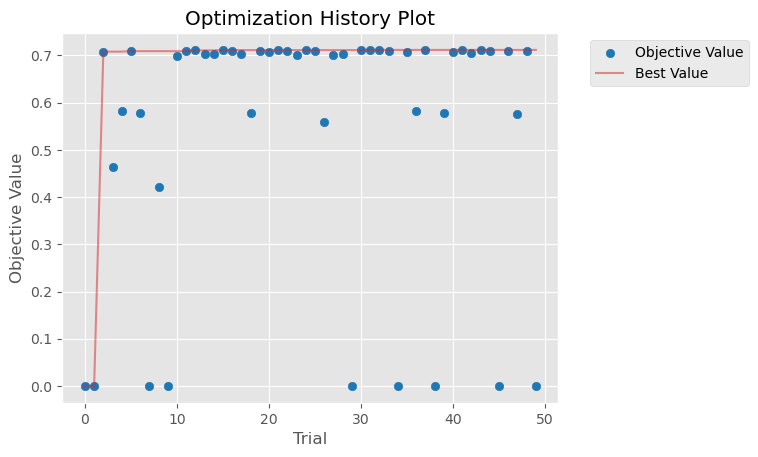

In [46]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

C:\Users\main\AppData\Local\Temp\ipykernel_24152\429335526.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


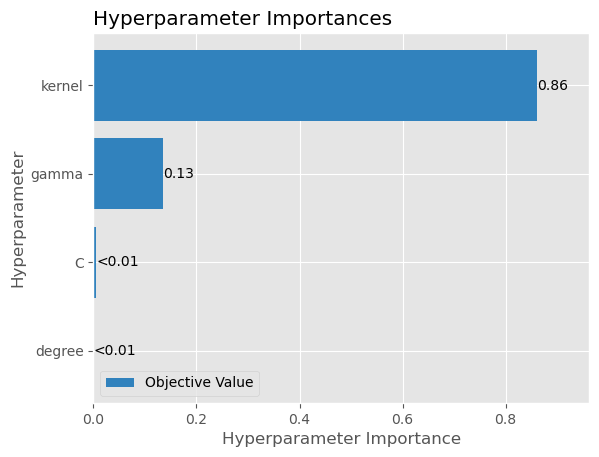

In [47]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

C:\Users\main\AppData\Local\Temp\ipykernel_24152\1753634641.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


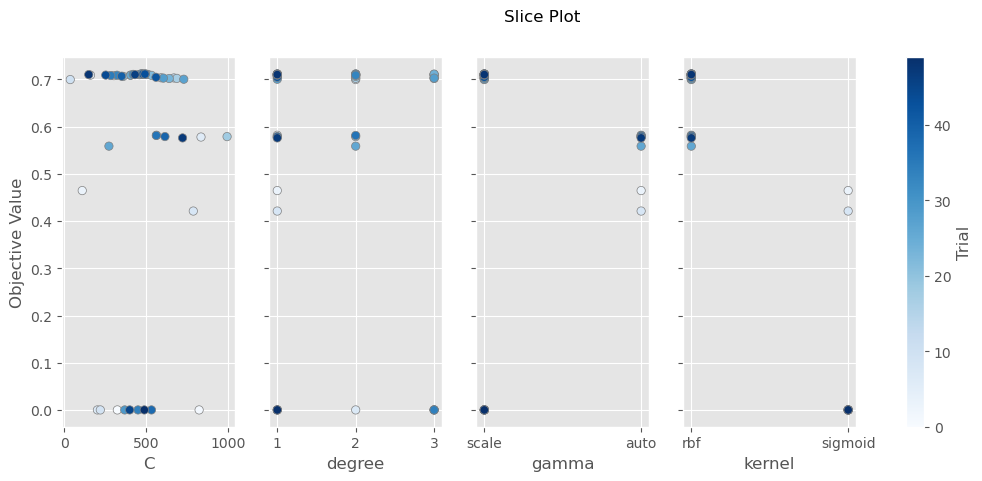

In [48]:
optuna.visualization.matplotlib.plot_slice(study)
plt.show()

C:\Users\main\AppData\Local\Temp\ipykernel_24152\192900552.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study)
[W 2024-04-20 18:31:06,852] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


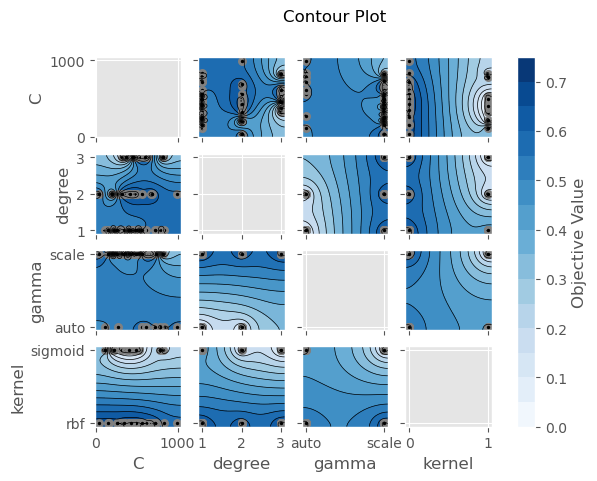

In [49]:
optuna.visualization.matplotlib.plot_contour(study)
plt.show()

# cross_validation

In [50]:
vC = [0.001, 0.01, 0.1, 1, 10]
vGamma = ['scale', 'auto']
param_grid = [
    {'kernel': ['poly'], 'C': vC, 'degree': [2, 3], 'gamma': vGamma},
    {'kernel': ['rbf'], 'C': vC, 'gamma': vGamma},
    {'kernel': ['sigmoid'], 'C': vC, 'gamma': vGamma, },
]

grid_search = GridSearchCV(SVC(), param_grid, scoring='f1', verbose=4, cv=NUM_FOLDS, n_jobs=-1)
grid_search.fit(train_x, train_y)

print(f'SVC test accuracy: {grid_search.score(test_x, test_y):0.2%}')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
SVC test accuracy: 69.25%


In [51]:
best_model = grid_search.best_estimator_
print(f'Best model: {best_model}, best params: {grid_search.best_params_}')

print(f'Best model score: {best_model.score(test_x, test_y):0.2%}')

Best model: SVC(C=10), best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best model score: 68.25%


In [53]:
C_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
f1_scores_rbf = []
for C in C_values:
    # print(f'start for C = {C}')
    svc = SVC(kernel=grid_search.best_params_['kernel'], C=C,gamma=grid_search.best_params_['gamma'])
    svc.fit(train_x, train_y)
    y_pred = svc.predict(test_x)
    f1 = f1_score(test_y, y_pred)
    f1_scores_rbf.append(f1)
    # print(f'end for C = {C}')

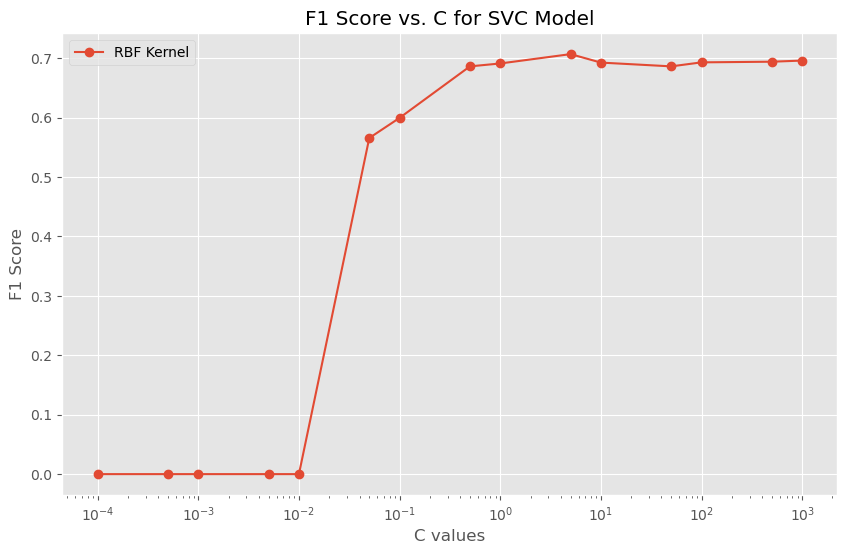

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(C_values, f1_scores_rbf, marker='o', label='RBF Kernel')
plt.title('F1 Score vs. C for SVC Model')
plt.xlabel('C values')
plt.ylabel('F1 Score')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [56]:
C_values = np.linspace(0.1, 10000, 15)
f1_scores_rbf = []
for C in C_values:
    # print(f'start for C = {C}')
    svc = SVC(kernel=grid_search.best_params_['kernel'], C=C,gamma=grid_search.best_params_['gamma'])
    svc.fit(train_x, train_y)
    y_pred = svc.predict(test_x)
    f1 = f1_score(test_y, y_pred)
    f1_scores_rbf.append(f1)
    # print(f'end for C = {C}')

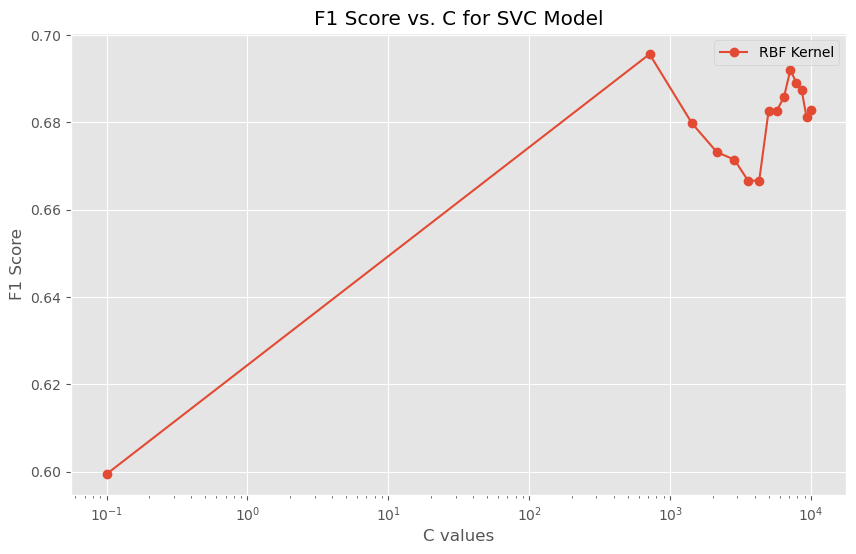

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(C_values, f1_scores_rbf, marker='o', label='RBF Kernel')
plt.title('F1 Score vs. C for SVC Model')
plt.xlabel('C values')
plt.ylabel('F1 Score')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [58]:
C_values = np.linspace(600, 900, 10)
f1_scores_rbf = []
for C in C_values:
    print(f'start for C = {C}')
    svc = SVC(kernel=grid_search.best_params_['kernel'], C=C,gamma=grid_search.best_params_['gamma'])
    svc.fit(train_x, train_y)
    y_pred = svc.predict(test_x)
    f1 = f1_score(test_y, y_pred)
    f1_scores_rbf.append(f1)
    print(f'end for C = {C}')

start for C = 600.0
end for C = 600.0
start for C = 633.3333333333334
end for C = 633.3333333333334
start for C = 666.6666666666666
end for C = 666.6666666666666
start for C = 700.0
end for C = 700.0
start for C = 733.3333333333334
end for C = 733.3333333333334
start for C = 766.6666666666667
end for C = 766.6666666666667
start for C = 800.0
end for C = 800.0
start for C = 833.3333333333334
end for C = 833.3333333333334
start for C = 866.6666666666667
end for C = 866.6666666666667
start for C = 900.0
end for C = 900.0


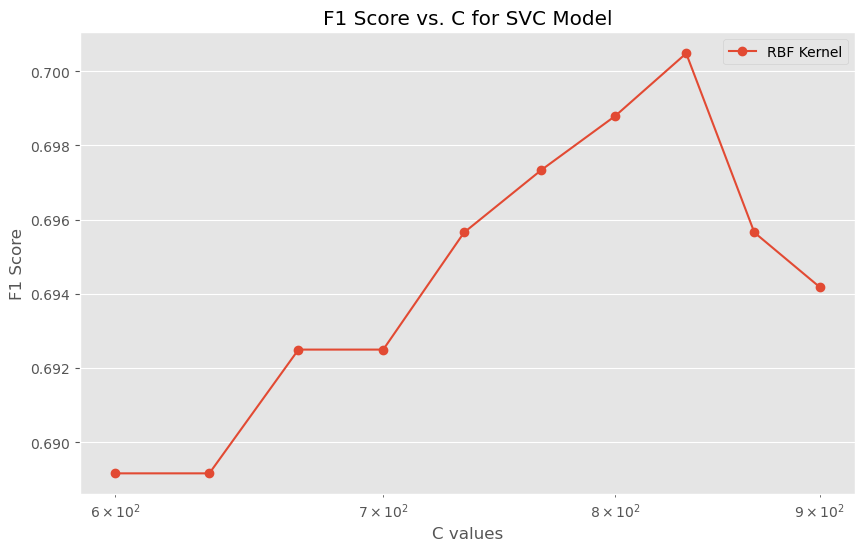

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(C_values, f1_scores_rbf, marker='o', label='RBF Kernel')
plt.title('F1 Score vs. C for SVC Model')
plt.xlabel('C values')
plt.ylabel('F1 Score')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [60]:
C_values = np.linspace(650, 720, 10)
f1_scores_rbf = []
for C in C_values:
    print(f'start for C = {C}')
    svc = SVC(kernel=grid_search.best_params_['kernel'], C=C,gamma=grid_search.best_params_['gamma'])
    svc.fit(train_x, train_y)
    y_pred = svc.predict(test_x)
    f1 = f1_score(test_y, y_pred)
    f1_scores_rbf.append(f1)
    print(f'end for C = {C}')

start for C = 650.0
end for C = 650.0
start for C = 657.7777777777778
end for C = 657.7777777777778
start for C = 665.5555555555555
end for C = 665.5555555555555
start for C = 673.3333333333334
end for C = 673.3333333333334
start for C = 681.1111111111111
end for C = 681.1111111111111
start for C = 688.8888888888889
end for C = 688.8888888888889
start for C = 696.6666666666666
end for C = 696.6666666666666
start for C = 704.4444444444445
end for C = 704.4444444444445
start for C = 712.2222222222222
end for C = 712.2222222222222
start for C = 720.0
end for C = 720.0


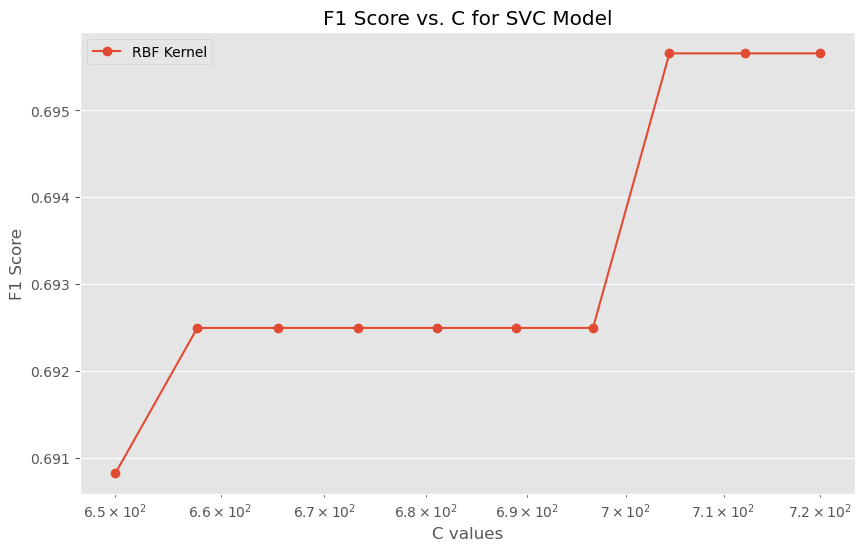

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(C_values, f1_scores_rbf, marker='o', label='RBF Kernel')
plt.title('F1 Score vs. C for SVC Model')
plt.xlabel('C values')
plt.ylabel('F1 Score')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [62]:
C_values = np.linspace(700, 715, 15)
f1_scores_rbf = []
for C in C_values:
    print(f'start for C = {C}')
    svc = SVC(kernel=grid_search.best_params_['kernel'], C=C,gamma=grid_search.best_params_['gamma'])
    svc.fit(train_x, train_y)
    y_pred = svc.predict(test_x)
    f1 = f1_score(test_y, y_pred)
    f1_scores_rbf.append(f1)
    print(f'end for C = {C}')

start for C = 700.0
end for C = 700.0
start for C = 701.0714285714286
end for C = 701.0714285714286
start for C = 702.1428571428571
end for C = 702.1428571428571
start for C = 703.2142857142857
end for C = 703.2142857142857
start for C = 704.2857142857143
end for C = 704.2857142857143
start for C = 705.3571428571429
end for C = 705.3571428571429
start for C = 706.4285714285714
end for C = 706.4285714285714
start for C = 707.5
end for C = 707.5
start for C = 708.5714285714286
end for C = 708.5714285714286
start for C = 709.6428571428571
end for C = 709.6428571428571
start for C = 710.7142857142857
end for C = 710.7142857142857
start for C = 711.7857142857143
end for C = 711.7857142857143
start for C = 712.8571428571429
end for C = 712.8571428571429
start for C = 713.9285714285714
end for C = 713.9285714285714
start for C = 715.0
end for C = 715.0


end for C = 715.0


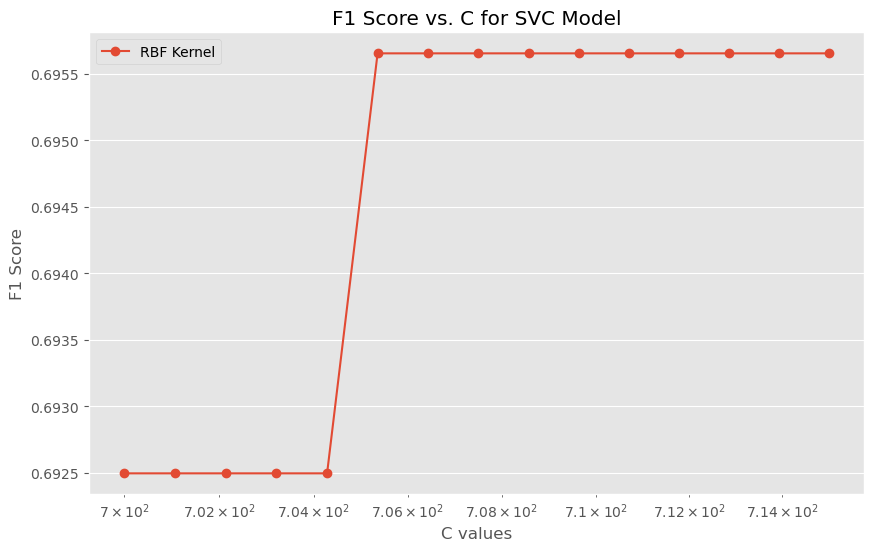

In [63]:
print(f'end for C = {C}')
plt.figure(figsize=(10, 6))
plt.plot(C_values, f1_scores_rbf, marker='o', label='RBF Kernel')
plt.title('F1 Score vs. C for SVC Model')
plt.xlabel('C values')
plt.ylabel('F1 Score')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [64]:
ideal_svc = SVC(kernel=grid_search.best_params_['kernel'], C=707,gamma=grid_search.best_params_['gamma'])
ideal_svc.fit(train_x, train_y)
ideal_y_pred = ideal_svc.predict(test_x)

In [65]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(test_y, ideal_y_pred)

print("Train Accuracy:", train_accuracy)

Train Accuracy: 0.685


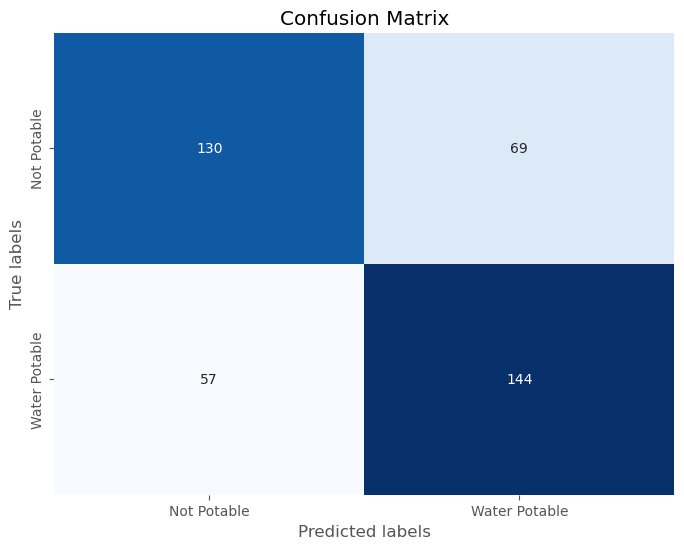

In [66]:
labels = ['Not Potable','Water Potable']
cm = confusion_matrix(test_y, ideal_y_pred,labels=[0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [67]:
calibrated_svc = CalibratedClassifierCV(ideal_svc, cv=NUM_FOLDS)
calibrated_svc.fit(train_x, train_y)

print(f'Calibrated SVC test accuracy: {calibrated_svc.score(test_x, test_y):0.2%}')

Calibrated SVC test accuracy: 67.50%


In [68]:
calibrated_svc.predict_proba(test_x)

array([[0.49719731, 0.50280269],
       [0.52657088, 0.47342912],
       [0.43139413, 0.56860587],
       [0.43471497, 0.56528503],
       [0.49925056, 0.50074944],
       [0.48393097, 0.51606903],
       [0.5259697 , 0.4740303 ],
       [0.57218515, 0.42781485],
       [0.67536713, 0.32463287],
       [0.16541184, 0.83458816],
       [0.4328589 , 0.5671411 ],
       [0.63508866, 0.36491134],
       [0.42922084, 0.57077916],
       [0.3903404 , 0.6096596 ],
       [0.34005218, 0.65994782],
       [0.3970697 , 0.6029303 ],
       [0.41957801, 0.58042199],
       [0.53788409, 0.46211591],
       [0.34891404, 0.65108596],
       [0.07330868, 0.92669132],
       [0.60296026, 0.39703974],
       [0.41490558, 0.58509442],
       [0.47476335, 0.52523665],
       [0.70283592, 0.29716408],
       [0.55143336, 0.44856664],
       [0.55871031, 0.44128969],
       [0.29406381, 0.70593619],
       [0.44825217, 0.55174783],
       [0.45580749, 0.54419251],
       [0.18231333, 0.81768667],
       [0.

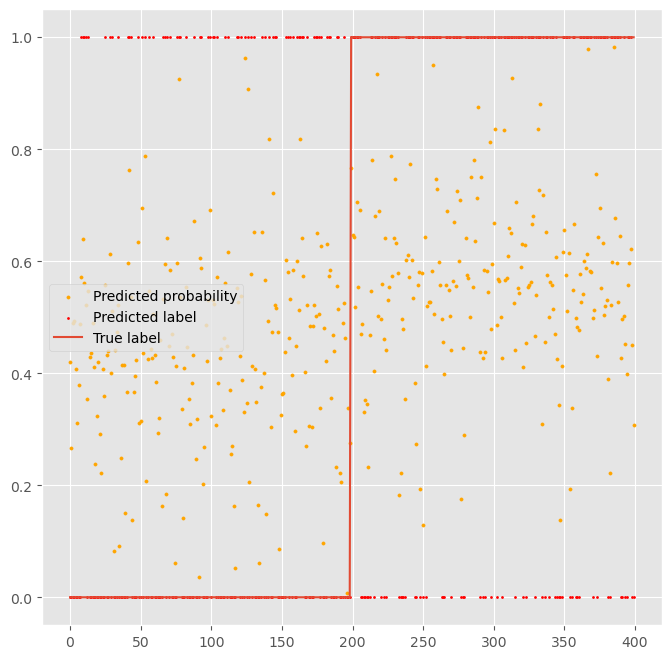

In [69]:
# Create a zipped array of sample index, predicted proability and true label
results = np.column_stack((calibrated_svc.predict_proba(test_x)[:, 1], calibrated_svc.predict(test_x), test_y))

# Sort by true label
results = results[results[:, 2].argsort()]

# Plot the predicted probabilities & true labels

plt.figure(figsize=(8, 8))
plt.scatter(range(len(results)), results[:, 0], label='Predicted probability', c='orange', s=5)
plt.scatter(range(len(results)), results[:, 1], label='Predicted label', c='red', s=2)
plt.plot(results[:, 2], label='True label')
plt.legend()

plt.show()

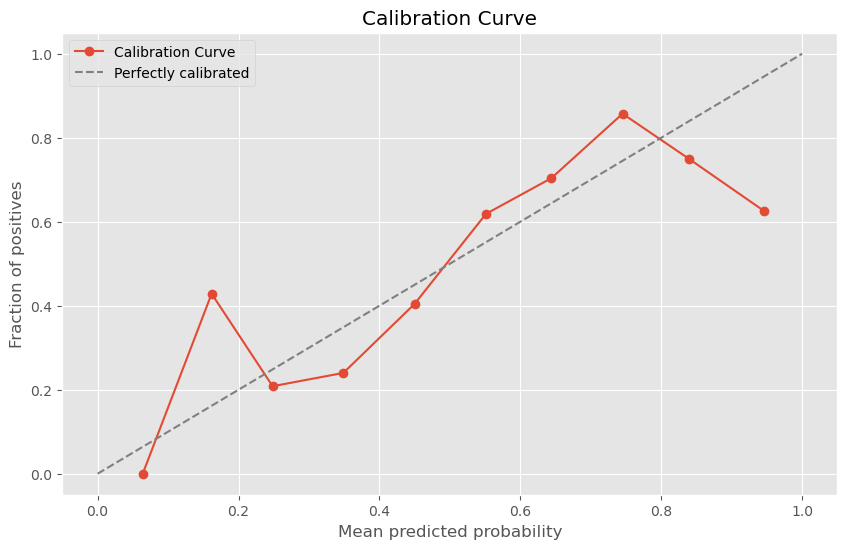

In [70]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(test_y, calibrated_svc.predict_proba(test_x)[:, 1], n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()